In [1]:
import torch
import matplotlib.pyplot as plt
from tailnflows.models import flows
from tailnflows.targets.heavy_tailed_nuisance import log_density, generate_data
from tailnflows.plot_utils import plot_contour

/home/th17628/miniconda/envs/tailnflows/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


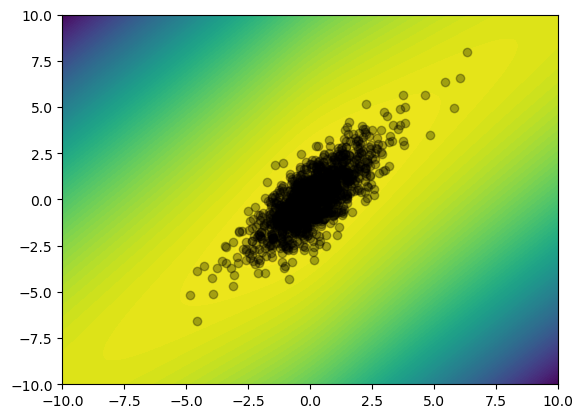

In [2]:
# sense check data + distribution
target_df = 5.

x_trn = generate_data(1300, 2, target_df)
x_val = generate_data(650, 2, target_df)
x_tst = generate_data(3000, 2, target_df)

fig, ax = plt.subplots(1, 1)
plot_contour(
    ax, 
    lambda x: log_density(x,target_df), 
    x_trn.shape[1], 
    target_x_0=-2,
    target_x_1=-1,
    min=-10,
    max=10,
    num_levels=100
)
ax.scatter(x_trn[:, 0], x_trn[:, 1], alpha=0.3, c='black')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.show()

### Model: TTF_m

normal -> auto reg RQS -> auto reg affine -> tail marginal

In [3]:
from tailnflows.train.data_fit import train
from functools import partial

dim = 2
tails = torch.tensor([1 / target_df, 1 / target_df])

flow = flows.build_ttf_m(
    dim,
    'density_estimation',
    base_transformation_init=partial(
        flows.base_nsf_transform,
        affine_autoreg_layer=True,
    ),
    model_kwargs=dict(
        pos_tail_init=tails,
        neg_tail_init=tails,
        fix_tails=True,
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=5e-3, num_epochs=300, batch_size=100, label='')

/home/th17628/tailnflows/tailnflows/models/flows.py:408: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_tail_init=torch.tensor(pos_tail_init),
/home/th17628/tailnflows/tailnflows/models/flows.py:409: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_tail_init=torch.tensor(neg_tail_init),
  0%|          | 0/300 [00:00<?, ?it/s]

 55%|█████▌    | 166/300 [01:13<00:59,  2.27it/s, loss=3.06 (3.09) : *3.065 @ 160]


KeyboardInterrupt: 

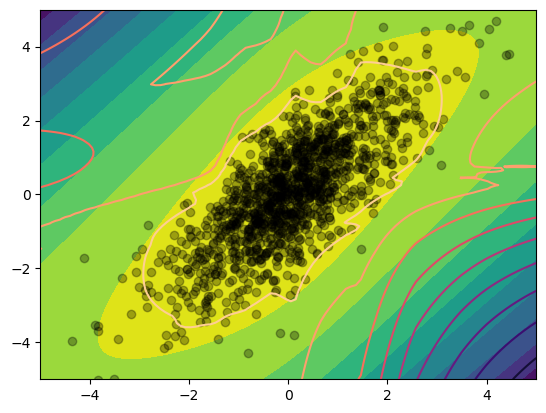

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_density(x,target_df), x_trn.shape[1], target_x_0=-2, target_x_1=-1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=-2, target_x_1=-1, contour_type='line')
ax.scatter(x_trn[:, 0], x_trn[:, 1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()

### Model: MTAF

In [19]:
dim = 2
dfs = torch.tensor([target_df, target_df])

flow = flows.build_mtaf(
    dim,
    'density_estimation',
    base_transformation_init=partial(
        flows.base_nsf_transform,
        affine_autoreg_layer=True,
    ),
    model_kwargs=dict(
        tail_init=dfs,
        fix_tails=True,
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=1e-3, num_epochs=500, batch_size=100, label='')

100%|██████████| 500/500 [00:35<00:00, 14.17it/s, loss=2.83 (3.05) : *3.078 @ 497]


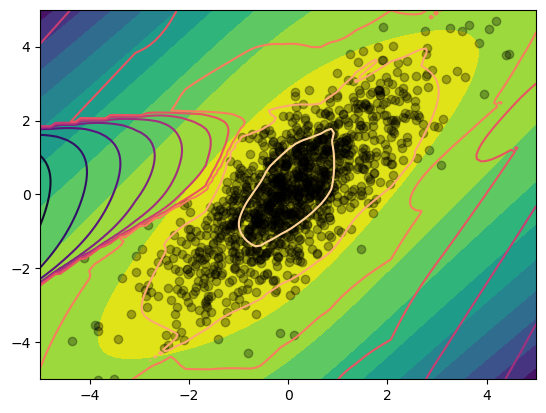

In [20]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_density(x,target_df), x_trn.shape[1], target_x_0=-2, target_x_1=-1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=-2, target_x_1=-1, contour_type='line')
ax.scatter(x_trn[:, -2], x_trn[:, -1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()

### Model: COMET

In [13]:
dim = 2

flow = flows.build_comet(
    dim,
    'density_estimation',
    base_transformation_init=partial(
        flows.base_nsf_transform,
        affine_autoreg_layer=True,
    ),
    model_kwargs=dict(
        data=x_trn,
        fix_tails=True,
        tail_init=[target_df, target_df]
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=1e-3, num_epochs=500, batch_size=100, label='')

100%|██████████| 500/500 [02:05<00:00,  3.98it/s, loss=4.22 (3.77) : *4.023 @ 424]


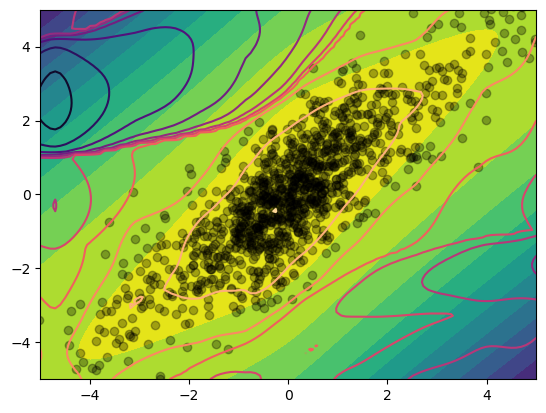

In [15]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_density(x,target_df), x_trn.shape[1], target_x_0=0, target_x_1=1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=0, target_x_1=1,contour_type='line')
ax.scatter(x_trn[:, -2], x_trn[:, -1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()